# TP – Éléments Finis : Problème de Laplace avec conditions mixtes

## 🎯 Objectif

On cherche à résoudre par la méthode des éléments finis le problème de **Laplace** sur le carré unité, avec **conditions aux limites mixtes (Dirichlet et Neumann)** :

# Equations aux dérivées partielles elliptiques

Nous nous intéressons à la résolution numérique d’un **problème elliptique** (type Laplace) à l’aide de la **méthode des éléments finis (MEF)**, sur le domaine 

$ \Omega = ]0,1[ \times ]0,1[ \subset \mathbb{R}^2 $

muni de conditions aux limites mixtes :

- $ u = u_d $ sur $ \partial\Omega_d $ (condition de Dirichlet),
- $ \dfrac{\partial u}{\partial n} = g $ sur $ \partial\Omega_n $ (condition de Neumann),
- $ -\Delta u = f $ dans $ \Omega $.

Le problème s’écrit donc :

$$
\begin{cases}
- \Delta u(x,y) = f(x,y), & \text{dans } \Omega, \\
u(x,y) = u_d(x,y), & \text{sur } \partial\Omega_d, \\
\dfrac{\partial u}{\partial n} = g(x,y), & \text{sur } \partial\Omega_n.
\end{cases}
$$


On introduit $ v = u - u_d \in H^1_0(\Omega) $, et on cherche $ v $ tel que pour tout $ w \in H^1_0(\Omega) $ :

$$
\int_{\Omega} \nabla v \cdot \nabla w \, dx = \int_{\Omega} f w \, dx + \int_{\partial\Omega_n} g w \, ds - \int_{\Omega} \nabla u_d \cdot \nabla w \, dx.
$$

## Discrétisation

En utilisant des éléments finis de type $ \mathbb{P}_1 $, on obtient un système linéaire :


$$
A \mathbf{x} = \mathbf{b},
$$

avec :

$$
A_{ij} = \int_{\Omega} \nabla \eta_i \cdot \nabla \eta_j \, dx,
$$

$$
b_i = \int_{\Omega} f \eta_i \, dx + \int_{\partial\Omega_n} g \eta_i \, ds - \sum_k U_k \int_{\Omega} \nabla \eta_i \cdot \nabla \eta_k \, dx.
$$

Ce système admet une solution unique grâce aux propriétés de coercivité et de continuité de la formulation variationnelle.


In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u):
#
    
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

### Assemblage du système linéaire par éléments finis

La résolution du problème de Laplace par la méthode des éléments finis de type $ \mathbb{P}_1 $ nécessite la construction de la matrice de rigidité $A$ et du vecteur second membre $b$ associés à la formulation variationnelle.

Le code ci-dessous comporte trois fonctions principales :

- `M_A_T(triangle, coordinates)` : calcule la matrice élémentaire de rigidité $M_T$ sur un triangle donné à partir des coordonnées de ses sommets. Elle utilise le gradient des fonctions de base affines associées aux éléments $ \mathbb{P}_1 $ et la formule classique :

$$
M_{ij} = \frac{|T|}{2} \, \nabla \eta_i \cdot \nabla \eta_j
$$

- `assemblage_A_et_b(coordinates, elements3, f)` : assemble globalement la matrice $A$ et le vecteur $b$ en sommant les contributions de chaque triangle. L’intégrale de la charge $f$ est approchée en utilisant la valeur au centre de gravité du triangle.

- `assemblage_triangle(coordinates, elements3, dirichlet, ud, f)` : applique les conditions de Dirichlet en modifiant le système, résout le système linéaire restreint aux degrés de liberté intérieurs, et restitue la solution $U$ complète sur tout le maillage.




In [4]:
def M_A_T(triangle,coordinates):
    M=np.zeros((3,3))
    sommets=coordinates[triangle,:]
    x=sommets[:,0]
    y=sommets[:,1]
    a = (x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0])
    for i in range(3):
        for j in range(3):
            grad_i = (1/a) * np.array([y[(i+1)%3]-y[(i+2)%3], x[(i+2)%3]-x[(i+1)%3]])
            grad_j = (1/a) * np.array([y[(j+1)%3]-y[(j+2)%3], x[(j+2)%3]-x[(j+1)%3]])
            M[i,j] = (a/2) * (np.transpose(grad_i)@(grad_j))
    return M, a


def assemblage_A_et_b(coordinates, elements3, f):
    N_T = elements3.shape[0]
    n = coordinates.shape[0]
    b = np.zeros((n,1))
    A = np.zeros((n,n))
    
    for p in range(N_T):
        triangle = elements3[p,:]
        vertices = coordinates[triangle]
        xg, yg = np.sum(vertices/3, axis=0)
        M_T, alpha = M_A_T(triangle, coordinates)
        A[triangle[:,None], triangle] += M_T
        b[triangle] += np.ones((3,1)) * (alpha/6) * f(xg,yg)
        
    return A, b
def assemblage_triangle(coordinates, elements3, dirichlet, ud, f):
    n = coordinates.shape[0]
    U = np.zeros((n,1))
    
    for sommet in dirichlet:
        vertices = coordinates[sommet][0]
        U[sommet] = ud(vertices[0], vertices[1])
    
    A, b = assemblage_A_et_b(coordinates, elements3, f)
    b = b - A @ U
    
    # l'intérieur de omega 
    interieur = np.setdiff1d(np.arange(len(coordinates)), dirichlet)
    A_int = A[interieur][:,interieur]
    b_int = b[interieur]
    sol = np.linalg.solve(A_int, b_int)
    
    U[interieur] = sol
    
    return A_int, b_int, U



    

**Exemple de problème EDP à résoudre**

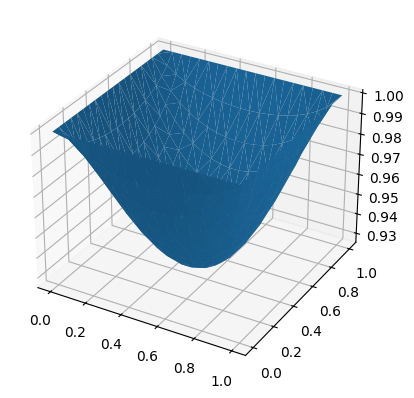

In [5]:

def f(x,y):
    return -1

def u_d(x,y):
    return 1

coordinates, elements3, dirichlet, neumann = maillage(20)
A,b, sol = assemblage_triangle(coordinates, elements3, dirichlet,u_d,f)



sol = sol.flatten()
show(coordinates, sol)

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [6]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

## Matrice de raideur pour les éléments finis de type quadrangle

Pour les éléments finis quadrilatéraux à 4 nœuds ($\mathbb{Q}_1$), les fonctions de forme sont définies sur l’élément de référence $[0,1]^2$ en coordonnées locales $(\xi, \zeta)$ avec leurs gradients :

$$
\begin{aligned}
\nabla \varphi_1 &= \begin{pmatrix} \frac{\partial \varphi_1}{\partial \xi} \\ \frac{\partial \varphi_1}{\partial \zeta} \end{pmatrix} = \begin{pmatrix} -1 + \zeta \\ -1 + \xi \end{pmatrix}, \quad
\nabla \varphi_2 = \begin{pmatrix} 1 - \zeta \\ -\xi \end{pmatrix}, \\
\nabla \varphi_3 &= \begin{pmatrix} \zeta \\ \xi \end{pmatrix}, \quad
\nabla \varphi_4 = \begin{pmatrix} -\zeta \\ 1 - \xi \end{pmatrix}.
\end{aligned}
$$

La matrice de raideur élémentaire est donnée par :

$$
M_{ij} = \int_0^1 \int_0^1 \nabla \varphi_i^T \left(J_\phi^T J_\phi\right)^{-1} \nabla \varphi_j \, |J_\phi| \, d\xi d\zeta,
$$

où $J_\phi$ est la matrice jacobienne du changement de variable (de l’élément de référence vers l’élément physique), $|J_\phi|$ son déterminant, et

$$
\left(J_\phi^T J_\phi\right)^{-1} = \begin{pmatrix} a & b \\ b & c \end{pmatrix}.
$$

---

### Calcul explicite des termes

En utilisant la symétrie de $M$ et une quadrature adaptée, on obtient pour les termes de la matrice :

$$
\begin{aligned}
M_{11} &= |J_\phi| \left( \frac{a}{3} + \frac{c}{3} + \frac{b}{2} \right), \\
M_{22} &= |J_\phi| \left( \frac{a}{3} + \frac{c}{3} - \frac{b}{2} \right), \\
M_{33} &= |J_\phi| \left( \frac{a}{3} + \frac{b}{2} + \frac{c}{3} \right), \\
M_{44} &= |J_\phi| \left( \frac{a}{3} - \frac{b}{2} + \frac{c}{3} \right), \\
M_{12} &= |J_\phi| \left( \frac{c}{6} - \frac{a}{3} \right), \\
M_{13} &= |J_\phi| \left( -\frac{a}{6} - \frac{c}{6} - \frac{b}{2} \right), \\
M_{14} &= |J_\phi| \left( \frac{a}{6} - \frac{c}{3} \right), \\
M_{23} &= |J_\phi| \left( \frac{a}{6} - \frac{c}{3} \right), \\
M_{24} &= |J_\phi| \left( \frac{b}{2} - \frac{a}{6} - \frac{c}{6} \right), \\
M_{34} &= |J_\phi| \left( \frac{c}{6} - \frac{a}{3} \right).
\end{aligned}
$$

La matrice complète symétrique s’écrit donc :

$$
M = \frac{|J_\phi|}{6} \begin{pmatrix}
2a + 3b + 2c & -2a + c & -a - 3b - c & a - 2c \\
-2a + c & 2a - 3b + 2c & a - 2c & -a + 3b - c \\
 -a - 3b - c & a - 2c & 2a + 3b + 2c & -2a + c \\
 a - 2c & -a + 3b - c & -2a + c & 2a - 3b + 2c
\end{pmatrix}.
$$

---

Ce développement permet de calculer efficacement la matrice élémentaire sur chaque quadrangle en utilisant uniquement les coefficients $a$, $b$, $c$ extraits de la matrice jacobienne, évitant ainsi une quadrature coûteuse sur chaque élément.


In [7]:
def M_A_Q(quad, coordinates):
    M=np.zeros((4,4))
    sommets=coordinates[quad,:]
    x=sommets[:,0]
    y=sommets[:,1]

    J = np.array([[x[1]-x[0], x[3]-x[0]], [y[1]-y[0], y[3]-y[0]]])
    C = np.linalg.inv (J.T @ J)

    a = C[0,0]
    b = C[1,0]
    c = C[1,1]

    detJ = np.linalg.det(J)
    
    M = (detJ/6) * np.array([
        [2*a + 3*b + 2*c, -2*a + c, -a - 3*b - c, a - 2*c],
        [-2*a + c, 2*a - 3*b + 2*c, a - 2*c, -a + 3*b - c],
        [-a - 3*b - c, a - 2*c, 2*a + 3*b + 2*c, -2*a + c],
        [a - 2*c, -a + 3*b - c, -2*a + c, 2*a - 3*b + 2*c]
    ])


    return M ,detJ
    


    

In [8]:
def assemblage_maille_mixte(coordinates, elements3, elements4, f):
    A, b = assemblage_A_et_b(coordinates, elements3, f)
    
    for q in elements4:
        vertices = coordinates[q]
        xg, yg = np.mean(vertices, axis=0)
        M_Q,detJ = M_A_Q(q,coordinates)
        A[q[:, None], q] += M_Q
        b[q] += np.ones((4, 1)) * (detJ / 4) * f(xg, yg)
    return A, b

coordinates = ccs
elements3 = e3
elements4 = e4
dirichlet = dds
neumann = nns
 U = np.zeros((n, 1))

def assemblage_maille_mixte_complete(coordinates, elements3, elements4, dirichlet, neumann, ud, f, g):
    n = coordinates.shape[0]
    U = np.zeros((n, 1))
    
    for i in dirichlet:
        xi, yi = coordinates[i]
        U[i] = ud(xi, yi)
    
    A, b = assemblage_maille_mixte(coordinates, elements3, elements4, f)
    
    for i, j in neumann:
        xi, yi = coordinates[i]
        xj, yj = coordinates[j]
        xm, ym = (xi + xj) / 2, (yi + yj) / 2
        longueur = np.linalg.norm([xi - xj, yi - yj])
        contribution = (longueur / 2) * g(xm, ym)
        b[i] += contribution
        b[j] += contribution
    
    b -= A @ U
    
    interieur = np.setdiff1d(np.arange(n), dirichlet)
    A_int = A[interieur][:, interieur]
    b_int = b[interieur]
    
    sol = np.linalg.solve(A_int, b_int)
    U[interieur] = sol
    
    return A_int, b_int, U






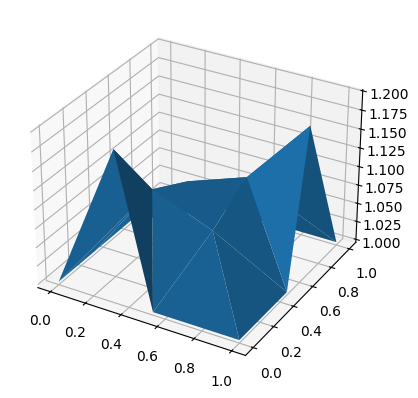

In [9]:
def f(x,y) :
    return 1

def g(x,y) :
    return 1

def u_d(x,y):
    return 1


A_int,b_int, U = assemblage_maille_mixte_complete(ccs, e3,e4, dds,nns,u_d,f,g)


U = U.flatten()

show(ccs, U)

**Compléments  :  un nouveau terme dans l'EDP**

# Résolution du problème elliptique avec terme de masse

On considère le problème suivant posé sur un domaine $\Omega$ :

\[
\begin{cases}
-\Delta u(x,y) + c_0 u(x,y) = f(x,y) & \text{dans } \Omega, \\
u(x,y) = 0 & \text{sur } \partial \Omega,
\end{cases}
\]

avec une constante $c_0 > 0$.

---

## 2.1 Formulation variationnelle

### Question 1 : Formulation variationnelle et unicité

**Formulation variationnelle :**

On cherche $u \in H_0^1(\Omega)$ telle que pour tout $w \in H_0^1(\Omega)$,

\[
\int_\Omega \nabla u \cdot \nabla w \, dx + c_0 \int_\Omega u w \, dx = \int_\Omega f w \, dx.
\]

**Démonstration :**

- Multiplier l’équation différentielle par $w \in H_0^1(\Omega)$ et intégrer sur $\Omega$ :

\[
\int_\Omega (-\Delta u + c_0 u) w \, dx = \int_\Omega f w \, dx.
\]

- En intégrant par parties le terme en $-\Delta u$ et utilisant $w=0$ sur $\partial \Omega$ :

\[
\int_\Omega \nabla u \cdot \nabla w \, dx + c_0 \int_\Omega u w \, dx = \int_\Omega f w \, dx.
\]

**Existence et unicité de la solution :**

La forme bilinéaire

\[
a(u,w) = \int_\Omega \nabla u \cdot \nabla w \, dx + c_0 \int_\Omega u w \, dx
\]

est continue et coercive sur $H_0^1(\Omega)$ car :

- La coercivité suit de Poincaré : il existe $C_P>0$ tel que $\|u\|_{L^2} \le C_P \|\nabla u\|_{L^2}$,
- donc $a(u,u) \ge \|\nabla u\|_{L^2}^2 + c_0 \|u\|_{L^2}^2 \ge \min(1, c_0 C_P^{-2}) \|u\|_{H^1_0}^2$.

La forme linéaire $L(w) = \int_\Omega f w \, dx$ est continue sur $H_0^1(\Omega)$.

Ainsi, par le théorème de Lax-Milgram, il existe une unique solution $u \in H_0^1(\Omega)$.

---

### Question 2 : Formulation variationnelle discrète et système linéaire

**Discrétisation par éléments finis :**

On approxime $H_0^1(\Omega)$ par un espace fini $V_h = \text{span}\{\eta_1, \ldots, \eta_n\}$ où les $\eta_i$ sont les fonctions de base associées aux éléments finis de type $\mathbb{P}_1$ ou $\mathbb{Q}_1$.

On cherche $u_h = \sum_{j=1}^n x_j \eta_j \in V_h$ vérifiant

\[
a(u_h, w_h) = L(w_h), \quad \forall w_h \in V_h.
\]

En particulier pour $w_h = \eta_i$,

\[
a(u_h, \eta_i) = L(\eta_i) \implies \sum_{j=1}^n x_j a(\eta_j, \eta_i) = L(\eta_i).
\]

Cela donne le système linéaire

\[
A \mathbf{x} = \mathbf{b}
\]

avec

\[
A_{ij} = \int_\Omega \nabla \eta_i \cdot \nabla \eta_j \, dx + c_0 \int_\Omega \eta_i \eta_j \, dx,
\]

\[
b_i = \int_\Omega f \eta_i \, dx.
\]

**Justification de l'existence et unicité de la solution discrète :**

- La matrice $A$ est symétrique définie positive (car $c_0>0$),
- donc la forme bilinéaire discrète est coercive sur $V_h$,
- ce qui garantit que le système linéaire a une solution unique $\mathbf{x} \in \mathbb{R}^n$.

---

Ainsi, la méthode des éléments finis produit un système discret bien posé, approchant la solution continue unique du problème.
**Existence et unicité de la solution :**

La forme bilinéaire

$$
a(u,w) = \int_\Omega \nabla u \cdot \nabla w \, dx + c_0 \int_\Omega u w \, dx
$$

est continue et coercive sur $H_0^1(\Omega)$ car :

- La coercivité suit de Poincaré : il existe $C_P>0$ tel que $\|u\|_{L^2} \le C_P \|\nabla u\|_{L^2}$,
- donc

$$
a(u,u) \ge \|\nabla u\|_{L^2}^2 + c_0 \|u\|_{L^2}^2 \ge \min(1, c_0 C_P^{-2}) \|u\|_{H^1_0}^2.
$$

La forme linéaire $L(w) = \int_\Omega f w \, dx$ est continue sur $H_0^1(\Omega)$.

Ainsi, par le théorème de Lax-Milgram, il existe une unique solution $u \in H_0^1(\Omega)$.

---

### Question 2 : Formulation variationnelle discrète et système linéaire

**Discrétisation par éléments finis :**

On approxime $H_0^1(\Omega)$ par un espace fini $V_h = \mathrm{span}\{\eta_1, \ldots, \eta_n\}$ où les $\eta_i$ sont les fonctions de base associées aux éléments finis de type $\mathbb{P}_1$ ou $\mathbb{Q}_1$.

On cherche $u_h = \sum_{j=1}^n x_j \eta_j \in V_h$ vérifiant

$$
a(u_h, w_h) = L(w_h), \quad \forall w_h \in V_h.
$$

En particulier pour $w_h = \eta_i$,

$$
a(u_h, \eta_i) = L(\eta_i) \implies \sum_{j=1}^n x_j a(\eta_j, \eta_i) = L(\eta_i).
$$

Cela donne le système linéaire

$$
A \mathbf{x} = \mathbf{b}
$$

avec

$$
A_{ij} = \int_\Omega \nabla \eta_i \cdot \nabla \eta_j \, dx + c_0 \int_\Omega \eta_i \eta_j \, dx,
$$

$$
b_i = \int_\Omega f \eta_i \, dx.
$$

**Justification de l'existence et unicité de la solution discrète :**

- La matrice $A$ est symétrique définie positive (car $c_0>0$),
- donc la forme bilinéaire discrète est coercive sur $V_h$,
- ce qui garantit que le système linéaire a une solution unique $\mathbf{x} \in \mathbb{R}^n$.

---

Ainsi, la méthode des éléments finis produit un système discret bien posé, approchant la solution continue unique du problème.


In [10]:
def calcule_M_T_2(triangle, coordinates, c0):
    M_raideur = np.zeros((3, 3))
    M_masse = np.zeros((3,3))
    pts = coordinates[triangle, :]
    x = pts[:, 0]
    y = pts[:, 1]
    alpha = (x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0])
    aire = abs(alpha)/2
    
    for i in range(3):
        for j in range(3):
            grad_i = (1/alpha) * np.array([y[(i+1)%3]-y[(i+2)%3], x[(i+2)%3]-x[(i+1)%3]])
            grad_j = (1/alpha) * np.array([y[(j+1)%3]-y[(j+2)%3], x[(j+2)%3]-x[(j+1)%3]])
            if i == j:
                M_raideur[i, j] = (alpha/2) * (np.dot(grad_i, grad_j)) 
                M_masse[i,j]= c0 * alpha/12
            else:
                M_raideur[i, j] = (alpha/2) * (np.dot(grad_i, grad_j)) 
                M_masse[i,j]=c0 * alpha/24

    M = M_raideur + M_masse
    return M, alpha

def calcule_M_Q_2(quad, coordinates, c0):
    M = np.zeros((4, 4))
    sommets = coordinates[quad, :]
    x = sommets[:, 0]
    y = sommets[:, 1]
    J = np.array([[x[1]-x[0], x[3]-x[0]], [y[1]-y[0], y[3]-y[0]]])
    C = np.linalg.inv(J.T @ J)
    a = C[0, 0]
    b = C[1, 0]
    c = C[1, 1]
    detJ = np.linalg.det(J)
    M_raideur = (detJ/6) * np.array([
        [2*a + 3*b + 2*c, -2*a + c, -a - 3*b - c, a - 2*c],
        [-2*a + c, 2*a - 3*b + 2*c, a - 2*c, -a + 3*b - c],
        [-a - 3*b - c, a - 2*c, 2*a + 3*b + 2*c, -2*a + c],
        [a - 2*c, -a + 3*b - c, -2*a + c, 2*a - 3*b + 2*c]
    ])
    
    M_masse = (detJ/36) * c0 *np.array([
        [4,2,1,2],
        [2,4,2,1],
        [1,2,4,2],
        [2,1,2,4]])
    
            
    
    M = M_raideur + M_masse
    
    return M, detJ



In [13]:
def resoudre_maillage_mixte(coordinates, elements3, elements4, dirichlet, c0, f):
    n = coordinates.shape[0]
    
    # Initialisation
    A = np.zeros((n, n))
    b = np.zeros((n, 1))
    U = np.zeros((n, 1))
    
    # Assemblage des triangles (votre code existant)
    N_T = elements3.shape[0]
    for p in range(N_T):
        triangle = elements3[p, :]
        vertices = coordinates[triangle]
        xg, yg = np.sum(vertices/3, axis=0)
        
        M_T, alpha = calcule_M_T_2(triangle, coordinates, c0)
        A[triangle[:, None], triangle] += M_T
        b[triangle] += np.ones((3, 1)) * (alpha/6) * f(xg, yg)
    
    # Assemblage des quadrangles
    N_Q = elements4.shape[0]
    for p in range(N_Q):
        quad = elements4[p, :]
        vertices = coordinates[quad]
        xg, yg = np.sum(vertices/4, axis=0)  # Centre de gravité (4 sommets)
        
        M_Q, detJ = calcule_M_Q_2(quad, coordinates, c0)
        A[quad[:, None], quad] += M_Q
        b[quad] += np.ones((4, 1)) * (abs(detJ)/4) * f(xg, yg)
    
    # Application des conditions de Dirichlet (votre méthode)
    interieur = np.array([i for i in range(len(coordinates)) if i not in dirichlet])
    
    # Résolution du système linéaire
    A_int = A[interieur][:, interieur]
    b_int = b[interieur]
    sol = np.linalg.solve(A_int, b_int)
    U[interieur] = sol
    
    return A_int, b_int, U

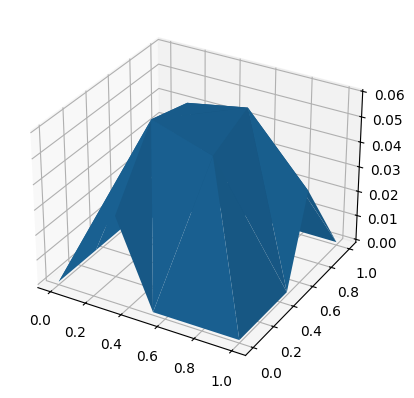

In [14]:
def f(x,y):
    return 1

c0 = 5

A,b, sol = resoudre_maillage_mixte(ccs, e3,e4, dds,c0,f)


sol = sol.flatten()
show(coordinates, sol)